In [73]:
from scipy import io
from scipy.stats import pearsonr
from scipy.io import loadmat 

import numpy as np
import pandas as pd
import seaborn as sns

from neurodsp import spectral
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_times

from fooof import FOOOF
from fooof.analysis import get_band_peak_fm

from bycycle.features import compute_features
from bycycle.group import compute_features_2d
from bycycle.plts import plot_burst_detect_summary, plot_feature_categorical
from bycycle.utils import flatten_dfs

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt

In [232]:
##Code is currently set up to run sessions seperately based on dyad and experiment 
data = loadmat('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp1/Dyad1Exp1vOBrrCapByMousePre.mat', squeeze_me=True) 
#data = data['vOBrrCapMouse'] 
data = data['vOBrrByMouse']

#data = np.loadtxt('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp2/Dyad1Exp2_bymousePre.txt') 
movement_data = pd.read_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Movement/MovementData-D1E1-ByPre.csv')
num_samples = len(data)

fs = 1000 #originally 30,000 - previously downsampled

Time = np.arange(0, num_samples / fs, 1 / fs)

data = pd.DataFrame({'Time': Time, 'EEG_Signal': data})
#movement_data.head()
data

,Time,EEG_Signal
0,0.000,0.114598
1,0.001,0.092876
2,0.002,0.071096
3,0.003,0.049290
4,0.004,0.027393
...,...,...
899995,899.995,-0.952129
899996,899.996,-0.990020
899997,899.997,-1.028717
899998,899.998,-1.068147


In [72]:
##import previous calculated bycycle results 
Dyad1_data = pd.read_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp1/Dyad1_All_data_WO_sniffing.txt', sep='\t')
Dyad3_data = pd.read_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad3Exp1/Dyad3_All_data_WO_sniffing.txt', sep='\t')


Dyad1_Bystander_Pre = Dyad1_data[(Dyad1_data['group'] == 2) & (Dyad1_data['experiment'] == 1)]
Dyad1_Bystander_Post = Dyad1_data[(Dyad1_data['group'] == 2) & (Dyad1_data['experiment'] == 2)]                                                          
Dyad1_Mouse_Pre = Dyad1_data[(Dyad1_data['group'] == 1) & (Dyad1_data['experiment'] == 1)]
Dyad1_Mouse_Post = Dyad1_data[(Dyad1_data['group'] == 1) & (Dyad1_data['experiment'] == 2)]                                                       
Dyad3_Bystander_Pre = Dyad3_data[(Dyad3_data['group'] == 2) & (Dyad3_data['experiment'] == 1)]
Dyad3_Bystander_Post = Dyad3_data[(Dyad3_data['group'] == 2) & (Dyad3_data['experiment'] == 2)]
Dyad3_Mouse_Pre = Dyad3_data[(Dyad3_data['group'] == 1) & (Dyad3_data['experiment'] == 1)]
Dyad3_Mouse_Post = Dyad3_data[(Dyad3_data['group'] == 1) & (Dyad1_data['experiment'] == 2)]

,time_rdsym,time_ptsym,period,time_trough,time_rise,time_decay,time_peak,time,group,experiment,mouse_id,dyad
10488,0.469880,0.410377,166,125,78,88,87,2,2,1,4,3
10489,0.387387,0.456140,111,62,43,68,52,2,2,1,4,3
10490,0.589623,0.408867,212,120,125,87,83,2,2,1,4,3
10491,0.449541,0.424000,109,72,49,60,53,2,2,1,4,3
10492,0.706667,0.308271,225,184,159,66,82,2,2,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
13158,0.528736,0.459184,87,53,46,41,45,1,2,1,4,3
13159,0.584158,0.505051,101,49,59,42,50,1,2,1,4,3
13160,0.684524,0.335366,168,109,115,53,55,1,2,1,4,3
13161,0.430108,0.500000,93,47,40,53,47,1,2,1,4,3


In [235]:
#Filter Data based on movement info (0: not moving) -- RUN THIS BLOCK TO FILTER INCLUDING MOVEMENT EXCEPT SNIFFING 
moving_periods = movement_data[(movement_data['Movement'] == 1)] #& (~movement_data['Movement_type'].isin([4, 5]))]
moving_eeg_data = pd.DataFrame(columns=['Time', 'EEG_Signal'])
moving_data_segments = []

for _, row in moving_periods.iterrows():
    start, end = row['Time_start'], row['Time_end']
    
    segment = data.loc[(data['Time'] >= start) & (data['Time'] <= end)]
    
    moving_data_segments.append(segment)

moving_data = pd.concat(moving_data_segments, ignore_index=True)
moving_data

,Time,EEG_Signal
0,4.500,0.001929
1,4.501,0.002429
2,4.502,0.001291
3,4.503,-0.001497
4,4.504,-0.005931
...,...,...
195665,891.129,-1.419157
195666,891.130,-1.413075
195667,891.131,-1.403275
195668,891.132,-1.389879


In [226]:
#Filter Data based on movement info (0: not moving) -- RUN THIS BLOCK TO FILTER INCLUDING ONLY NON-WALKING PERIODS, EXCLUDING SNIFFING
non_moving_periods = movement_data[(movement_data['Movement'] == 0)] #(~movement_data['Movement_type'].isin([4, 5]))]
non_moving_eeg_data = pd.DataFrame(columns=['Time', 'EEG_Signal'])
non_moving_data_segments = []

for _, row in non_moving_periods.iterrows():
    start, end = row['Time_start'], row['Time_end']
    
    segment = data.loc[(data['Time'] >= start) & (data['Time'] <= end)]
    
    non_moving_data_segments.append(segment)

non_moving_data = pd.concat(non_moving_data_segments, ignore_index=True)
non_moving_data

,Time,EEG_Signal
0,0.200,-0.730744
1,0.201,-0.782392
2,0.202,-0.833863
3,0.203,-0.884963
4,0.204,-0.935462
...,...,...
705588,899.995,-0.952129
705589,899.996,-0.990020
705590,899.997,-1.028717
705591,899.998,-1.068147


In [236]:
##RUN THIS BLOCK TO BIN PRE DATA INTO 5 MINUTE BINS

# Define bin intervals (in seconds)
bin_intervals = [(0, 300), (300.001, 600), (600.001, 900)]

binned_data = {}

# Iterate over bins and filter data into separate DataFrames
for i, (bin_start, bin_end) in enumerate(bin_intervals, start=0):
    bin_df = moving_data[(moving_data['Time'] >= bin_start) & (moving_data['Time'] <= bin_end)]
    binned_data[f'bin_{i}'] = bin_df  # Save each bin with a key like 'bin_1', 'bin_2', etc.

# Each bin is now stored as a separate DataFrame in the dictionary
# Example: Access bin 1 using binned_data['bin_1']

binned_data

{'bin_0':           Time  EEG_Signal
 0        4.500    0.001929
 1        4.501    0.002429
 2        4.502    0.001291
 3        4.503   -0.001497
 4        4.504   -0.005931
 ...        ...         ...
 43101  288.405    1.036270
 43102  288.406    1.002073
 43103  288.407    0.964411
 43104  288.408    0.923309
 43105  288.409    0.878851
 
 [43106 rows x 2 columns],
 'bin_1':            Time  EEG_Signal
 43106   306.264    1.500293
 43107   306.265    1.550837
 43108   306.266    1.597348
 43109   306.267    1.639623
 43110   306.268    1.677537
 ...         ...         ...
 119822  582.348    0.187322
 119823  582.349    0.163546
 119824  582.350    0.136332
 119825  582.351    0.105773
 119826  582.352    0.071977
 
 [76721 rows x 2 columns],
 'bin_2':            Time  EEG_Signal
 119827  600.036   -0.959419
 119828  600.037   -1.006168
 119829  600.038   -1.054794
 119830  600.039   -1.105190
 119831  600.040   -1.157193
 ...         ...         ...
 195665  891.129   -1.419157

In [208]:
##RUN THIS BLOCK TO BIN POST DATA INTO 5 MINUTE BINS 

# Define bin intervals (in seconds)
bin_intervals = [(0, 300), (300.001, 600), (600.001, 900), (900.001, 1200), (1200.001, 1500), (1500.001, 1800)]

binned_data = {}

# Iterate over bins and filter data into separate DataFrames
for i, (bin_start, bin_end) in enumerate(bin_intervals, start=0):
    bin_df = moving_data[(moving_data['Time'] >= bin_start) & (moving_data['Time'] <= bin_end)]
    binned_data[f'bin_{i}'] = bin_df  # Save each bin with a key like 'bin_1', 'bin_2', etc.

# Each bin is now stored as a separate DataFrame in the dictionary
# Example: Access bin 1 using binned_data['bin_1']

binned_data

{'bin_0':            Time  EEG_Signal
 0       159.400   -1.198104
 1       159.401   -1.202301
 2       159.402   -1.205431
 3       159.403   -1.207584
 4       159.404   -1.208818
 ...         ...         ...
 282445  210.816    0.475113
 282446  210.817    0.431467
 282447  210.818    0.389152
 282448  210.819    0.348264
 282449  210.820    0.308927
 
 [53683 rows x 2 columns],
 'bin_1':            Time  EEG_Signal
 26262   489.327    1.829891
 26263   489.328    1.873717
 26264   489.329    1.914175
 26265   489.330    1.951130
 26266   489.331    1.984644
 ...         ...         ...
 405371  516.972   -1.627717
 405372  516.973   -1.679220
 405373  516.974   -1.728024
 405374  516.975   -1.773847
 405375  516.976   -1.816507
 
 [74844 rows x 2 columns],
 'bin_2':            Time  EEG_Signal
 100832  600.001    1.120360
 100833  600.002    1.095536
 100834  600.003    1.070600
 100835  600.004    1.045487
 100836  600.005    1.020221
 ...         ...         ...
 405097  657.396

In [247]:
#EXTRACT RELEVANT BIN TO PROCESS W BYCYCLE 
#data = non_moving_data['EEG_Signal'].values
#data
Time = binned_data['bin_2']['Time'].values
data = binned_data['bin_2']['EEG_Signal'].values
#data

/var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/ipykernel_2062/637279257.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq_mean), np.log10(P_mean))


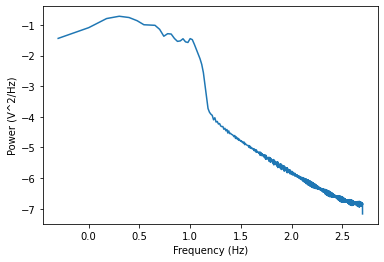

[  0.    0.5   1.  ... 499.  499.5 500. ]
[-2.28672675 -1.43955645 -1.08928404 ... -6.87985674 -6.82532536
 -7.17011777]


In [248]:
# Calculate power spectra
freq_mean, P_mean = spectral.compute_spectrum(data, fs, method='welch', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)
# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='welch')

# Plot PSD
plt.plot(np.log10(freq_mean), np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
#plt.xlim((1, 50))
#plt.ylim((-8, 5))
plt.show()

print(freq_mean)
print(np.log10(P_mean))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.10 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

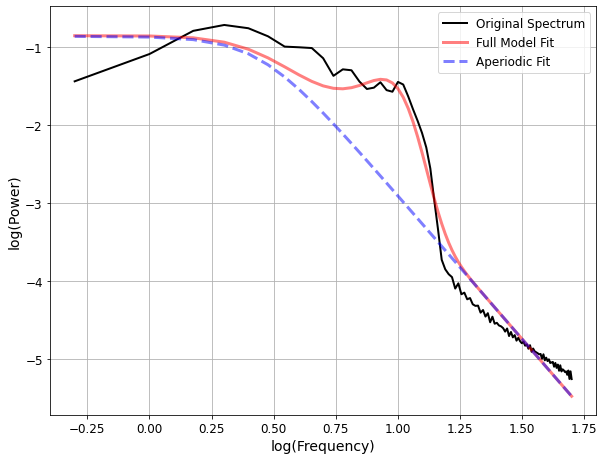

In [249]:
# Initialize a FOOOF object
fm = FOOOF(max_n_peaks = 1, peak_width_limits=[0.1, 50.0], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.5, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freq_mean, P_mean, freq_range, plt_log=True)

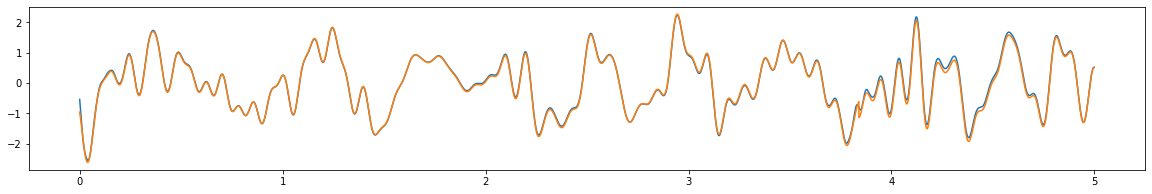

In [250]:
F_RANGE = (4, 12)
preprocess_f_range = (0.5, 30)

#preprocess data in 0.5 to 30 Hz range to get rid of any significant noise 
preproc_sig = filter_signal(data, fs, 'bandpass', preprocess_f_range, remove_edges=False)
#preprocess data in the frequency band of interest (aka the frequency band bycycle will be searching in) 

#use this data for later visualizations 
preproc_sig2 = filter_signal(data, fs, 'bandpass', F_RANGE, remove_edges=False)

# Plot raw and preprocessed signal
%matplotlib inline
times = create_times(len(preproc_sig) / fs, fs)
plt.figure(figsize=(20,3))
plt.plot(times[0:5000], preproc_sig[0:5000])
plt.plot(times[0:5000], data[0:5000])
plt.show()

In [231]:
# Tuned burst detection parameters
threshold_kwargs = {'amp_fraction_threshold': 0.1,
                    'amp_consistency_threshold': 0.2,
                    'period_consistency_threshold': 0.35,
                    'monotonicity_threshold': 0.85,
                    'min_n_cycles': 3}

# Compute waveform shape features for each mouse/exp 
#bycycle_2Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
D1E1_ByPre_nonmovement = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_nonmovement = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#done#D1E1_Pre_nonmovement = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)  
#Dyad3_bycycle_Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_2Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_2ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_2Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#Dyad3_bycycle_2ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)


#save output file locally
D1E1_ByPre_nonmovement.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp1/bycycle_nonmovement/D1E1_ByPre_nonmovement.txt', sep='\t', index=False)

In [251]:
# Tuned burst detection parameters
threshold_kwargs = {'amp_fraction_threshold': 0.1,
                    'amp_consistency_threshold': 0.2,
                    'period_consistency_threshold': 0.35,
                    'monotonicity_threshold': 0.85,
                    'min_n_cycles': 3}

# Compute waveform shape features for each bin (##3 bins for PRE data, 6 bins for POST data) 

#Mouse Pre - update dyad/experiment info
#D1E1_Pre_Bin0 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Pre_Bin1 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Pre_Bin2 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)

#Mouse Post - update dyad/experiment info 
#D1E1_Post_Bin0 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_Bin1 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_Bin2 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_Bin3 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_Bin4 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_Post_Bin5 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)

#By Mouse Pre - update dyad/experiment info
#D1E1_ByPre_Bin0 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPre_Bin1 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPre_Bin2 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)

By Mouse Post - update dyad/experiment info 
#D1E1_ByPost_Bin1 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPost_Bin2 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPost_Bin3 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPost_Bin4 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPost_Bin5 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#D1E1_ByPost_Bin6 = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)

#save output file locally
D1E1_ByPre_Bin2.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp1/bycycle_WO_sniffing/D1E1_ByPre_Bin2.txt', sep='\t', index=False)

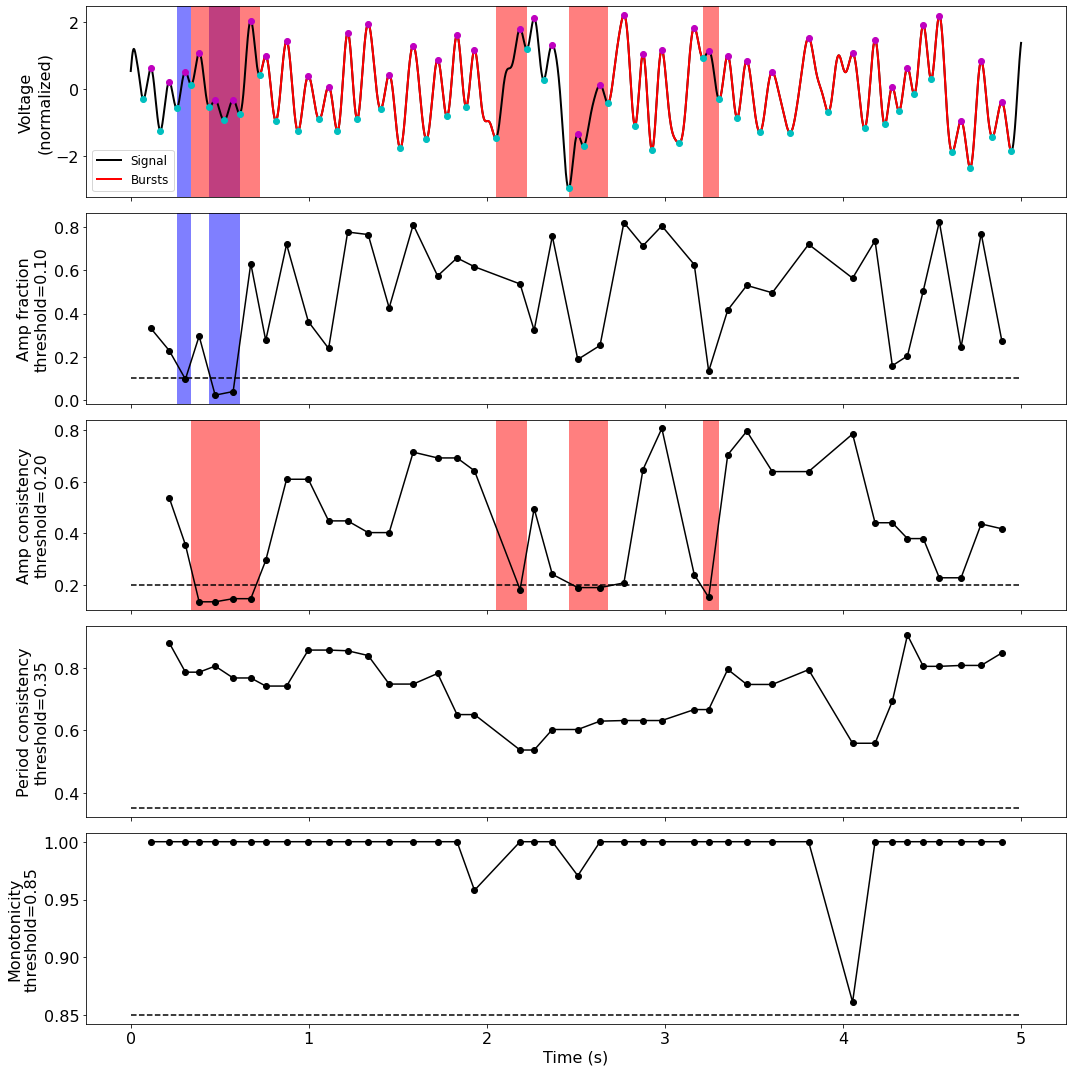

In [28]:
# Plot bursts
plot_burst_detect_summary(Dyad3_bycycle_Pre, preproc_sig[:5*fs], fs, threshold_kwargs, xlim=(0,5))

In [29]:
#check the number of bursts in data 

num_bursts = Dyad3_bycycle_Pre['is_burst'].sum()

total_cycles = len(Dyad3_bycycle_Pre)

print(f"Number of bursts: {num_bursts}")
print(f"Total number of cycles: {total_cycles}")
print(f"Percentage of cycles in bursts: {num_bursts / total_cycles * 100:.2f}%")

Number of bursts: 2409
Total number of cycles: 3624
Percentage of cycles in bursts: 66.47%


In [129]:
# Filter the DataFrames where 'is_burst' is True 
bycycle_Pre_burst = bycycle_Pre[bycycle_Pre['is_burst'] == True]
bycycle_Post_burst = bycycle_Post[bycycle_Post['is_burst'] == True]
bycycle_ByPre_burst = bycycle_ByPre[bycycle_ByPre['is_burst'] == True]
bycycle_ByPost_burst = bycycle_ByPost[bycycle_ByPost['is_burst'] == True]
bycycle_2Pre_burst = bycycle_2Pre[bycycle_2Pre['is_burst'] == True]
bycycle_2Post_burst = bycycle_2Post[bycycle_2Post['is_burst'] == True]
bycycle_2ByPre_burst = bycycle_2ByPre[bycycle_2ByPre['is_burst'] == True]
bycycle_2ByPost_burst = bycycle_2ByPost[bycycle_2ByPost['is_burst'] == True]
#Dyad3_bycycle_Pre_burst = Dyad3_bycycle_Pre[Dyad3_bycycle_Pre['is_burst'] == True]
#Dyad3_bycycle_Post_burst = Dyad3_bycycle_Post[Dyad3_bycycle_Post['is_burst'] == True]
#Dyad3_bycycle_ByPre_burst = Dyad3_bycycle_ByPre[Dyad3_bycycle_ByPre['is_burst'] == True]
#Dyad3_bycycle_ByPost_burst = Dyad3_bycycle_ByPost[Dyad3_bycycle_ByPost['is_burst'] == True]
#Dyad3_bycycle_2Pre_burst = Dyad3_bycycle_2Pre[Dyad3_bycycle_2Pre['is_burst'] == True]
#Dyad3_bycycle_2Post_burst = Dyad3_bycycle_2Post[Dyad3_bycycle_2Post['is_burst'] == True]
#Dyad3_bycycle_2ByPre_burst = Dyad3_bycycle_2ByPre[Dyad3_bycycle_2ByPre['is_burst'] == True]
#Dyad3_bycycle_2ByPost_burst = Dyad3_bycycle_2ByPost[Dyad3_bycycle_2ByPost['is_burst'] == True]

# bycycle params of interest 
breathing_variables = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'] 

#mouse id - bystander in exp 1 is mouse 2 
#group - Bystander = 2
bycycle_ByPost_burst = bycycle_ByPost_burst[breathing_variables].copy()
bycycle_ByPost_burst['time'] = 2
bycycle_ByPost_burst['group'] = 2
bycycle_ByPost_burst['experiment'] = 1
bycycle_ByPost_burst['mouse_id'] = 4
bycycle_ByPost_burst['dyad'] = 3

bycycle_ByPre_burst = bycycle_ByPre_burst[breathing_variables].copy()
bycycle_ByPre_burst['time'] = 1
bycycle_ByPre_burst['group'] = 2
bycycle_ByPre_burst['experiment'] = 1
bycycle_ByPre_burst['mouse_id'] = 4
bycycle_ByPre_burst['dyad'] = 3

bycycle_Post_burst = bycycle_Post_burst[breathing_variables].copy()
bycycle_Post_burst['time'] = 2
bycycle_Post_burst['group'] = 1
bycycle_Post_burst['experiment'] = 1
bycycle_Post_burst['mouse_id'] = 3
bycycle_Post_burst['dyad'] = 3

bycycle_Pre_burst = bycycle_Pre_burst[breathing_variables].copy()
bycycle_Pre_burst['time'] = 1
bycycle_Pre_burst['group'] = 1
bycycle_Pre_burst['experiment'] = 1
bycycle_Pre_burst['mouse_id'] = 3
bycycle_Pre_burst['dyad'] = 3

bycycle_2ByPost_burst = bycycle_2ByPost_burst[breathing_variables].copy()
bycycle_2ByPost_burst['time'] = 2
bycycle_2ByPost_burst['group'] = 2
bycycle_2ByPost_burst['experiment'] = 2
bycycle_2ByPost_burst['mouse_id'] = 3
bycycle_2ByPost_burst['dyad'] = 3

bycycle_2ByPre_burst = bycycle_2ByPre_burst[breathing_variables].copy()
bycycle_2ByPre_burst['time'] = 1
bycycle_2ByPre_burst['group'] = 2
bycycle_2ByPre_burst['experiment'] = 2
bycycle_2ByPre_burst['mouse_id'] = 3
bycycle_2ByPre_burst['dyad'] = 3

bycycle_2Post_burst = bycycle_2Post_burst[breathing_variables].copy()
bycycle_2Post_burst['time'] = 2
bycycle_2Post_burst['group'] = 1
bycycle_2Post_burst['experiment'] = 2
bycycle_2Post_burst['mouse_id'] = 4
bycycle_2Post_burst['dyad'] = 3

bycycle_2Pre_burst = bycycle_2Pre_burst[breathing_variables].copy()
bycycle_2Pre_burst['time'] = 1
bycycle_2Pre_burst['group'] = 1
bycycle_2Pre_burst['experiment'] = 2
bycycle_2Pre_burst['mouse_id'] = 4
bycycle_2Pre_burst['dyad'] = 3

Dyad1_all_data = pd.concat([bycycle_2ByPost_burst, bycycle_2ByPre_burst, bycycle_2Post_burst, bycycle_2Pre_burst, bycycle_ByPost_burst, bycycle_ByPre_burst, bycycle_Post_burst, bycycle_Pre_burst], ignore_index=True)
Dyad1_all_data.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp1/Dyad1_All_data_WO_sniffing.txt', sep='\t', index=False)
print(Dyad3_all_data)

       time_rdsym  time_ptsym  period  time_trough  time_rise  time_decay  \
0        0.476190    0.512195      84           40         40          44   
1        0.534091    0.494382      88           45         47          41   
2        0.431818    0.523810      88           40         38          50   
3        0.753165    0.475000     158           84        119          39   
4        0.494737    0.522222      95           43         47          48   
...           ...         ...     ...          ...        ...         ...   
16858    0.394619    0.680751     223           68         88         135   
16859    0.561224    0.471154      98           55         55          43   
16860    0.599119    0.407767     227          122        136          91   
16861    0.606061    0.418033      99           71         60          39   
16862    0.672131    0.645349     183           61        123          60   

       time_peak  time  group  experiment  mouse_id  dyad  
0             4

In [131]:
#save combined data locally 
#aggregated_data = all_data.groupby(['group', 'time', 'experiment', 'mouse_id'])['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'].mean().reset_index()
All_data.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/All_data_moving_WO_sniffing.txt', sep='\t', index=False)
#Dyad3_all_data = pd.DataFrame(Dyad3_all_data)

All_data = pd.concat([Dyad1_all_data, Dyad3_all_data], ignore_index=True)
#All_data
#dyad_1['dyad'] = 1
#dyad_1.head()

#load in bycycle data for dyad1 
#dyad_1 = pd.read_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/ALL_DATA_ANOVA_Moving.txt', sep=None, engine='python') 
#dyad_1 = pd.DataFrame(dyad_1)


#print(aggregated_data.dtypes)
#print(aggregated_data.isnull().sum())  # Check for missing values

In [ ]:
##ANALYSES

In [114]:
#aggregated_data['group'] = aggregated_data['group'].astype('category')
#aggregated_data['time'] = aggregated_data['time'].astype('category')
#aggregated_data['experiment'] = aggregated_data['experiment'].astype('category')

# RM ANOVA
for variables in breathing_variables:
    
    # Fit the model
    model = smf.ols(f'{dv} ~ C(group) * C(time) + C(experiment)', data=All_data).fit()
    
    # Perform the ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Print the results for each dependent variable
    print(anova_table)
    print("\n" + "="*50 + "\n")

# Post-hoc pairwise comparisons for 'group'
#posthoc_group = pg.pairwise_ttests(dv='period', between='group', data=aggregated_data, padjust='bonferroni')
#print(posthoc_group)

# Post-hoc pairwise comparisons for interaction 'group * time'
#posthoc_group_time = pg.pairwise_ttests(dv='period', between=['group', 'time'], data=aggregated_data, padjust='bonferroni')
#print(posthoc_group_time)

NameError: name 'dv' is not defined

In [139]:
# attempt at pingouin anova 
import pingouin as pg
#'time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'

anova_results = pg.rm_anova(
    data=All_data,
    dv='time_peak',             
    within=['time', 'group'],          
    subject='mouse_id',      
    detailed=True)

print(anova_results)

         Source         SS  ddof1  ddof2         MS           F     p-unc  \
0          time  29.705728      1      1  29.705728  168.942879  0.048883   
1         group  94.923388      1      1  94.923388  198.217639  0.045142   
2  time * group  61.944514      1      1  61.944514  913.621366  0.021054   

   p-GG-corr       ng2  eps  
0   0.048883  0.976248  1.0  
1   0.045142  0.992444  1.0  
2   0.021054  0.988467  1.0  


/Users/elizabethkaplan/opt/anaconda3/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/elizabethkaplan/opt/anaconda3/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


In [ ]:
#Linear regression
all_data['time'] = all_data['time'].astype('category')
all_data['group'] = all_data['group'].astype('category')

formula = 'time_peak ~ C(time) + C(group) + C(time):C(group)'

model = smf.ols(formula, data=all_data).fit()

print(model.summary())

In [ ]:
## VISUALIZATIONS

In [ ]:
#Plot segments with highest and lowest values for different variables so Monique's team can visualize their meaning 

#include 10 segments 
max_time_peak = peaks_df.nlargest(10, 'time_peak')['sample_peak']
min_period = peaks_df.nsmallest(10, 'period')['sample_peak']
min_time_rise = peaks_df.nsmallest(10, 'time_rise')['sample_peak']
min_time_decay = peaks_df.nsmallest(10, 'time_decay')['sample_peak']

segments = []

for peak_sample in min_time_decay:
    window_duration = 1
    window_samples = int(window_duration * fs)
        
    start_sample = max(peak_sample - window_samples // 2, 0)  # Ensure within bounds
    end_sample = min(peak_sample + window_samples // 2, len(preproc_sig2))  # Ensure within bounds
    
    segment = preproc_sig2[start_sample:end_sample]
    time = np.linspace(start_sample / sampling_frequency, 
                   end_sample / sampling_frequency, 
                   len(segment))
        
    segments.append({
    'peak_sample': peak_sample,
    'start_sample': start_sample,
    'end_sample': end_sample,
    'time': time,
    'segment': segment
    })


segments_df2 = pd.DataFrame(segments)
segments_df2

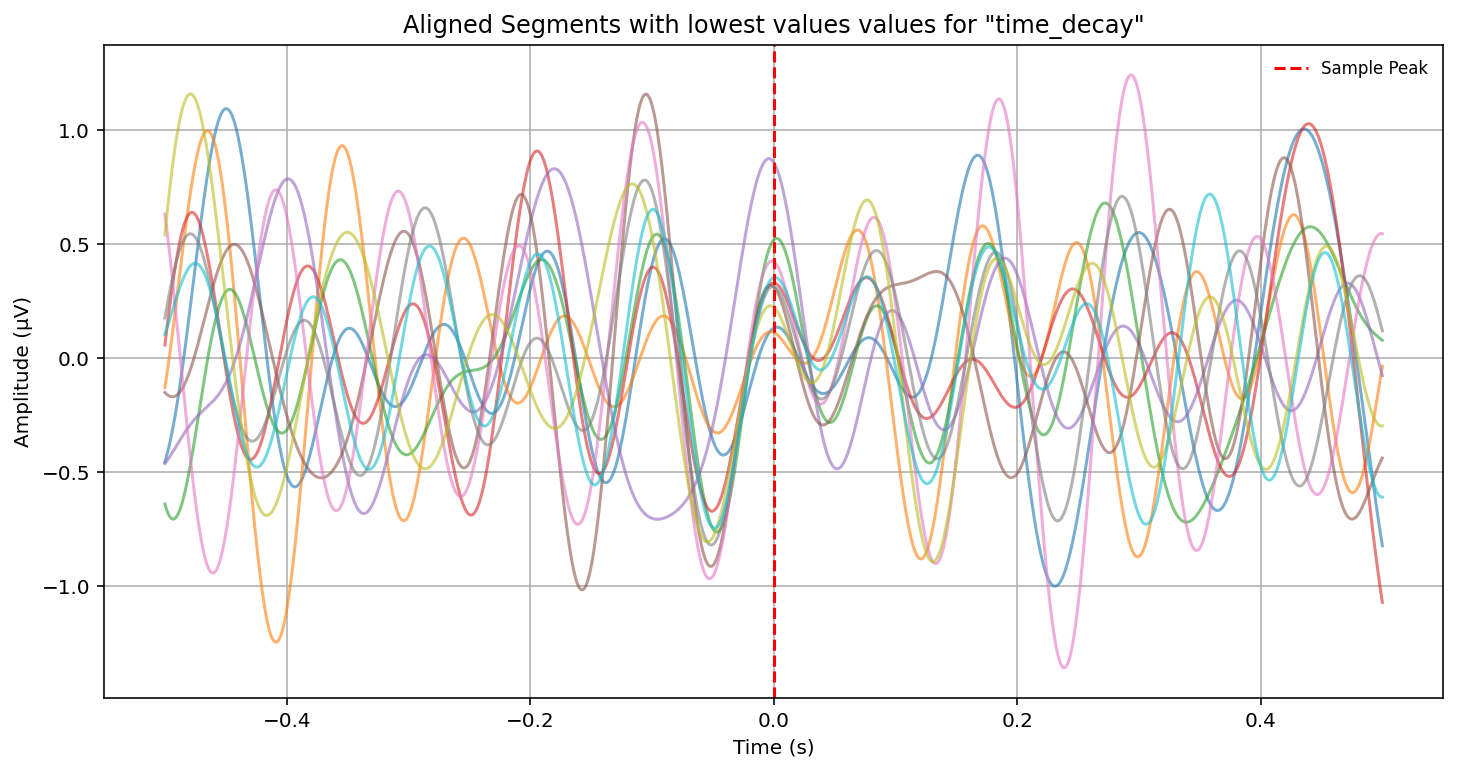

In [153]:
#Plot segments with highest and lowest values for different variables so Monique's team can visualize their meaning 
sampling_rate = 1000  
window_duration = 0.5  
time_vector = np.linspace(-window_duration, window_duration, int(window_duration * 2 * sampling_rate))

plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments_df2['segment']):

        plt.plot(time_vector, segment, alpha=0.6)  

plt.title('Aligned Segments with lowest values values for "time_decay"')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

In [ ]:
#plot all cycles on top of another 

plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments_df['segment']):
    if 1000 > i > 990:
        plt.plot(time_vector, segment, alpha=0.6, label=f'Segment {i+1}' if i < 10 else None)  # Limit labels for clarity


plt.title('Aligned Segments')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  # Mark the reference peak
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

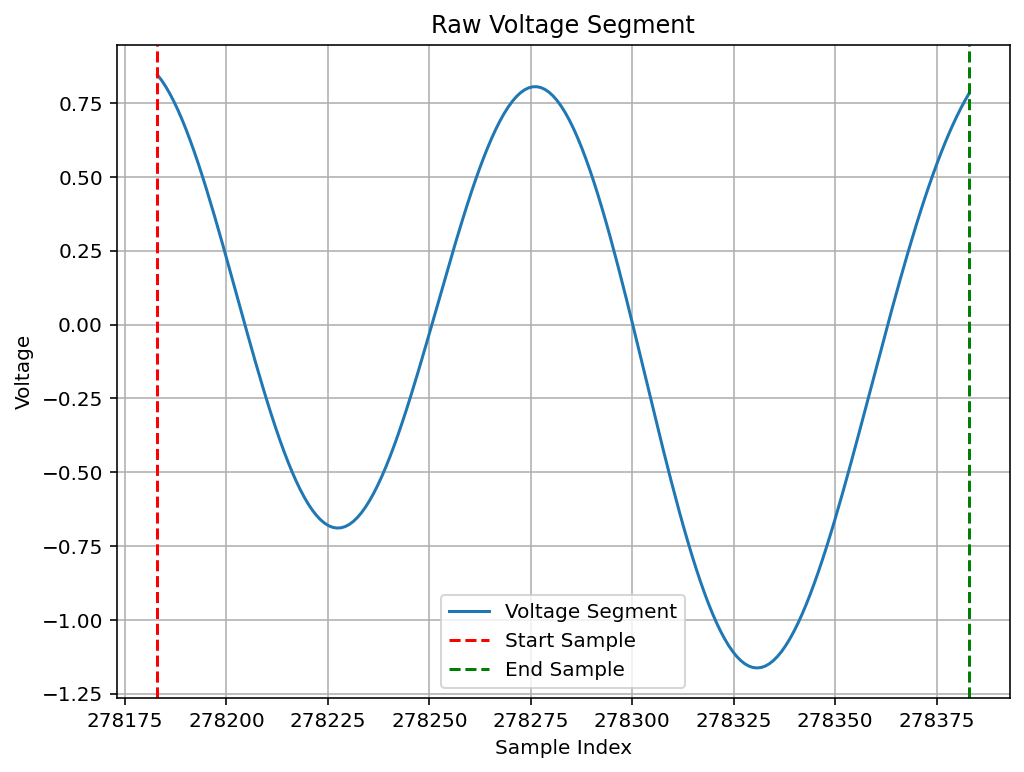

In [43]:
## plot individual cycles 
def plot_raw_segment(voltage_array, start_sample, end_sample):
    """
    Plot a raw segment from the voltage array based on start and end sample indices.

    Parameters:
        voltage_array (np.ndarray): 1D array of voltage values.
        start_sample (int): The start sample index for the segment.
        end_sample (int): The end sample index for the segment.

    Returns:
        None
    """
    segment = preproc_sig2[start_sample:end_sample]
    
    time = np.linspace(start_sample, end_sample, len(segment))
    
    plt.figure(figsize=(8, 6))
    plt.plot(time, segment, label="Voltage Segment")
    plt.axvline(x=start_sample, color='r', linestyle='--', label="Start Sample")
    plt.axvline(x=end_sample, color='g', linestyle='--', label="End Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage")
    plt.title("Raw Voltage Segment")
    plt.legend()
    plt.grid(True)
    plt.show()

start_sample = 278183 
end_sample = 278383    

plot_raw_segment(preproc_sig2, start_sample=start_sample, end_sample=end_sample)

In [ ]:
## heatmap correlations without excluding within-subject comparisons  

subset_data = df_bycycle_Post_NaN.iloc[:, :17]  #first 17 columns
columns_to_exclude = ['volt_decay', 'volt_rise', 'volt_amp', 'volt_peak', 'volt_trough', 'amp_fraction']  
subset_data = subset_data.drop(columns=columns_to_exclude, errors='ignore') 
correlation_matrix = subset_data.corr()  

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
## HEATMAPS PT2 (excluding within-subject comparisons)
variables_to_include = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak']  

post_mouse = df_bycycle_2Post[variables_to_include]
pre_mouse = df_bycycle_2Pre[variables_to_include]

post_mouse.columns = [f"{col}_post_mouse" for col in post_mouse.columns]
pre_mouse.columns = [f"{col}_pre_mouse" for col in pre_mouse.columns]

combined_data = pd.concat([post_mouse, pre_mouse], axis=1)

correlation_matrix = combined_data.corr()

mask = np.zeros_like(correlation_matrix, dtype=bool) 
columns_mouse1 = post_mouse.columns
columns_mouse2 = pre_mouse.columns

# Mask Mouse 1 vs Mouse 1 and Mouse 2 vs Mouse 2 correlations
for col1 in columns_mouse1:
    for col2 in columns_mouse1:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True
for col1 in columns_mouse2:
    for col2 in columns_mouse2:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True

upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask |= upper_triangle  

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', cbar=True)
plt.title("Between-Subject Correlations: Mouse 1 vs Mouse 2 (No Redundancy)")
plt.show()

In [112]:
#violin plots of variables of interest pre vs post 

feats_to_plot = {'volt_amp': 'Amplitude (μV)', 
                 'time_ptsym': 'Peak-Trough Asymmetry', 
                 'time_rdsym': 'Rise-Decay Asymmetry', 
                 'time_trough': 'Time}

def plot_violin_comparison(df1, df2, feats_to_plot):
    fig, axes = plt.subplots(1, len(feats_to_plot), figsize=(15, 5), sharey=True)
    
    for ax, (feat, title) in zip(axes, feats_to_plot.items()):
        data = [df1[feat], df2[feat]]
        ax.violinplot(data, showmeans=True)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Bystander Mouse Post', 'Mouse Post'])
        ax.set_ylabel(title)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

plot_violin_comparison(df_bycycle_ByPost, df_bycycle_Post, feats_to_plot)

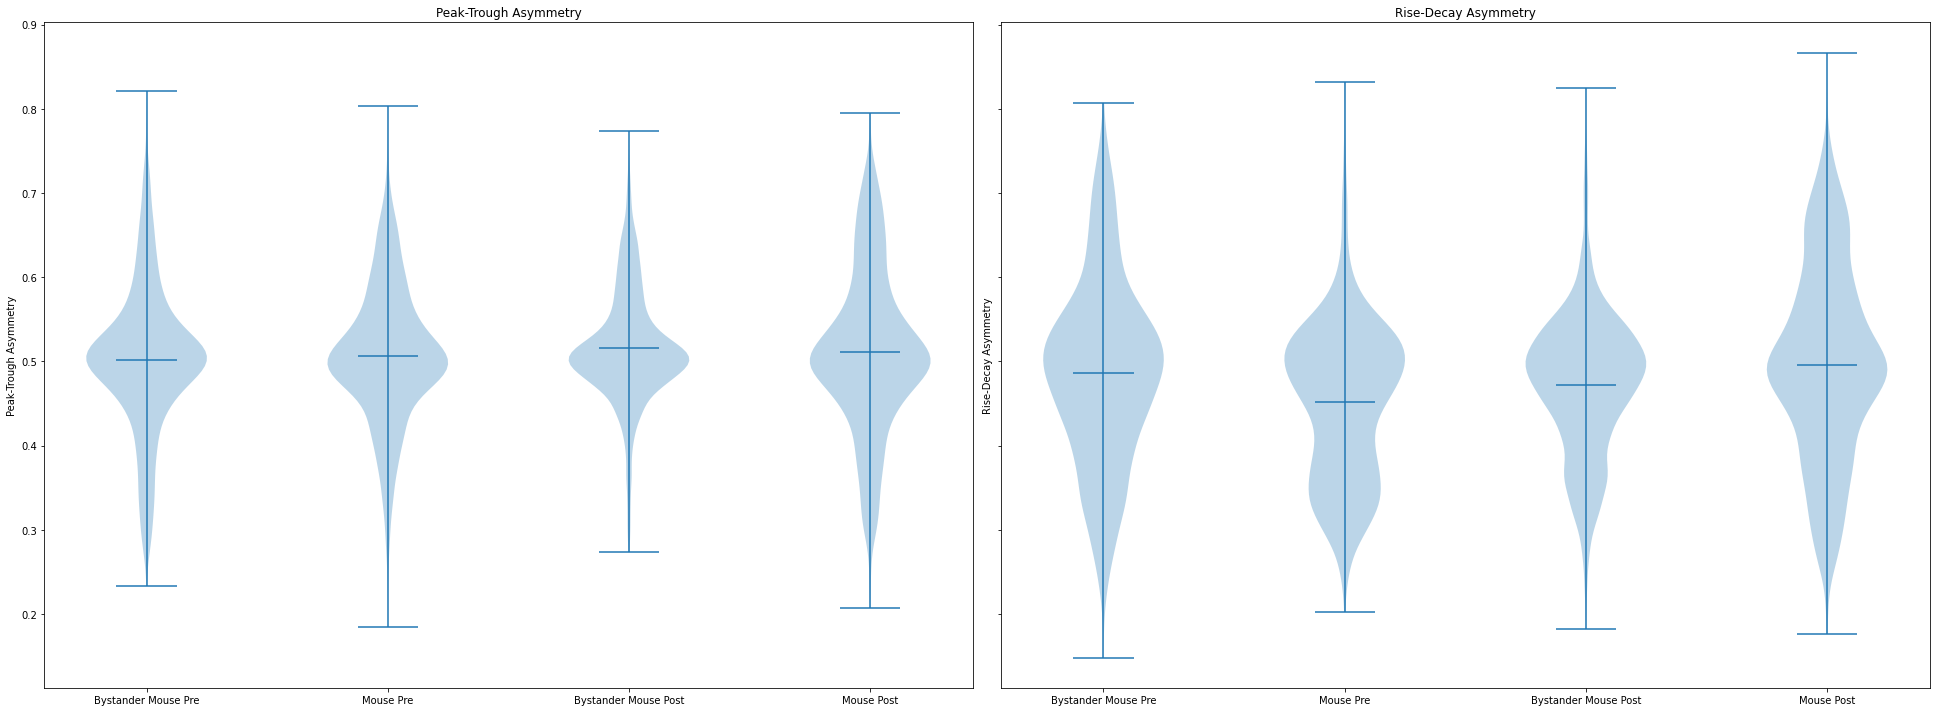

In [51]:
##visualizations of RM ANOVA results - violin plots 

feats_to_plot = {'time_ptsym': 'Peak-Trough Asymmetry', 
                 'time_rdsym': 'Rise-Decay Asymmetry',} 
                 #'period': 'Period',
                 #'time_trough': 'Trough Time',
                 #'time_peak': 'Peak Time', 
                 #'time_decay': 'Decay Time',
                 #'time_rise': 'Rise Time'}

def plot_violin_comparison(df1, df2, df3, df4, feats_to_plot):
    fig, axes = plt.subplots(1, len(feats_to_plot), figsize=(27, 10), sharey=True)
    
    for ax, (feat, title) in zip(axes, feats_to_plot.items()):
        data = [df1[feat], df2[feat], df3[feat], df4[feat]]
        ax.violinplot(data, showmeans=True)
        ax.set_xticks([1, 2, 3, 4])
        ax.set_xticklabels(['Bystander Mouse Pre', 'Mouse Pre', 'Bystander Mouse Post', 'Mouse Post'])
        ax.set_ylabel(title)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

plot_violin_comparison(Dyad1_Bystander_Pre, Dyad1_Mouse_Pre, Dyad1_Bystander_Post, Dyad1_Mouse_Post, feats_to_plot)